# Card Counting & Adaptive Betting

**Theme:** Can an RL agent discover card counting?   

### Imports & config

In [1]:
# Notebook 3 — Card Counting & Adaptive Betting

import random
from collections import defaultdict, deque
import math

import numpy as np
import matplotlib.pyplot as plt

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Hi-Lo buckets
TRUE_COUNT_BUCKETS = list(range(-5, 6))  # -5 .. +5 (cap extreme counts)

# Bet options (units)
BET_OPTIONS = [1, 2, 4, 8]

# Q-learning hyperparams for play policy
PLAY_EPISODES = 200_000
ALPHA_PLAY = 0.05
GAMMA = 1.0
EPS_START_PLAY = 0.2
EPS_END_PLAY = 0.02

# Betting training hyperparams
BET_EPISODES = 100_000
EPS_START_BET = 0.2
EPS_END_BET = 0.02

### Counting Blackjack Environment (multi-deck, penetration, Hi-Lo)

In [2]:
class CountingBlackjackEnv:
    """
    Multi-deck shoe with penetration and Hi-Lo running count.
    - Hi-Lo: 2-6 => +1, 7-9 => 0, 10/Ace => -1
    - Reshuffle when remaining cards < initial_size * (1 - penetration)
      (penetration expressed as fraction dealt before shuffle)
    """
    def __init__(self, n_decks=6, penetration=0.75, dealer_stands_soft17=True, blackjack_payout=1.5):
        self.n_decks = n_decks
        self.penetration = penetration
        self.dealer_stands_soft17 = dealer_stands_soft17
        self.blackjack_payout = blackjack_payout

        self.initial_shoe_size = 52 * self.n_decks
        # shuffle when remaining cards < (1 - penetration) * initial_size
        self.reshuffle_threshold = int(self.initial_shoe_size * (1.0 - self.penetration))
        self._init_shoe()

        # per-hand state
        self.player = []
        self.dealer = []
        self.allow_double = True

    # ---------- shoe and draws ----------
    def _init_shoe(self):
        one_deck = [1,2,3,4,5,6,7,8,9,10,10,10,10] * 4
        self.shoe = one_deck * self.n_decks
        random.shuffle(self.shoe)
        self.running_count = 0  # Hi-Lo running count

    def _count_card(self, card):
        # Hi-Lo: 2-6 +1, 7-9 0, 10/Ace -1
        if 2 <= card <= 6:
            return +1
        if card == 1 or card == 10:
            return -1
        return 0

    def _draw(self):
        if len(self.shoe) <= self.reshuffle_threshold:
            self._init_shoe()
        card = self.shoe.pop()
        self.running_count += self._count_card(card)
        return card

    def cards_remaining(self):
        return len(self.shoe)

    def true_count(self):
        # decks remaining (float)
        decks_rem = max(1e-6, len(self.shoe) / 52.0)
        tc = self.running_count / decks_rem
        # bucket and cap
        bucket = int(max(min(tc, TRUE_COUNT_BUCKETS[-1]), TRUE_COUNT_BUCKETS[0]))
        return tc, bucket

    # ---------- hand utilities ----------
    @staticmethod
    def _hand_value(cards):
        total = sum(cards)
        usable_ace = 1 in cards and total + 10 <= 21
        return (total + 10, True) if usable_ace else (total, False)

    @staticmethod
    def _is_blackjack(cards):
        return len(cards) == 2 and 1 in cards and sum(cards) + 10 == 21

    def _obs_play(self):
        total, usable = self._hand_value(self.player)
        upcard = self.dealer[0]
        _, bucket = self.true_count()
        return (total, upcard, usable, bucket, self.allow_double)

    # ---------- dealer policy ----------
    def _dealer_play(self):
        while True:
            total, usable = self._hand_value(self.dealer)
            if total < 17:
                self.dealer.append(self._draw())
                continue
            if total == 17 and usable and not self.dealer_stands_soft17:
                # H17 (rare if False), then hit
                self.dealer.append(self._draw())
                continue
            break

    def _compare(self, player_total, dealer_total):
        if player_total > 21:
            return -1
        if dealer_total > 21:
            return +1
        if player_total > dealer_total:
            return +1
        if player_total < dealer_total:
            return -1
        return 0

    # ---------- API ----------
    def observe_count_bucket(self):
        """Return current true_count (float) and bucket (int). Useful before betting."""
        return self.true_count()

    def reset_for_bet(self):
        """
        Returns the pre-deal observation for betting decision:
        (true_count_float, bucket)
        """
        # if shoe low, _draw will reshuffle on next draw anyway; but ensure shoe is ready
        if len(self.shoe) <= self.reshuffle_threshold:
            self._init_shoe()
        tc, bucket = self.true_count()
        return tc, bucket

    def deal_and_start_hand(self):
        """Deal two cards to player & dealer after bet is placed. Returns play-state obs and (possible immediate reward, done flag) if natural."""
        self.player = [self._draw(), self._draw()]
        self.dealer = [self._draw(), self._draw()]
        self.allow_double = True

        player_blackjack = self._is_blackjack(self.player)
        dealer_blackjack = self._is_blackjack(self.dealer)

        if player_blackjack or dealer_blackjack:
            if player_blackjack and dealer_blackjack:
                return self._obs_play(), 0.0, True
            elif player_blackjack:
                return self._obs_play(), self.blackjack_payout, True
            else:
                return self._obs_play(), -1.0, True

        return self._obs_play(), 0.0, False

    def step_play(self, action):
        """
        Play-phase step. action in {0=HIT,1=STAND,2=DOUBLE}
        Returns: obs, reward, done, info
        """
        HIT, STAND, DOUBLE = 0, 1, 2

        if action == DOUBLE and not self.allow_double:
            action = HIT

        if action == HIT:
            self.player.append(self._draw())
            self.allow_double = False
            total, _ = self._hand_value(self.player)
            if total > 21:
                return self._obs_play(), -1.0, True, {}
            return self._obs_play(), 0.0, False, {}

        if action == STAND:
            self.allow_double = False
            self._dealer_play()
            p_total, _ = self._hand_value(self.player)
            d_total, _ = self._hand_value(self.dealer)
            reward = self._compare(p_total, d_total)
            return self._obs_play(), float(reward), True, {}

        # DOUBLE
        self.player.append(self._draw())
        self.allow_double = False
        p_total, _ = self._hand_value(self.player)
        if p_total > 21:
            return self._obs_play(), -2.0, True, {"doubled": True}
        self._dealer_play()
        p_total, _ = self._hand_value(self.player)
        d_total, _ = self._hand_value(self.dealer)
        base = self._compare(p_total, d_total)
        return self._obs_play(), float(2 * base), True, {"doubled": True}

### Train play policy (Q-learning) — includes count bucket in state

In [3]:
# Reuse helpers from Notebook 2 but include count bucket in state vector
HIT, STAND, DOUBLE = 0, 1, 2
ACTION_NAMES = {HIT: "H", STAND: "S", DOUBLE: "D"}

def valid_actions_from_state_play(state):
    _, _, _, _, allow_double = state
    return [HIT, STAND, DOUBLE] if allow_double else [HIT, STAND]

def epsilon_greedy_play(Q, state, epsilon):
    valid = valid_actions_from_state_play(state)
    if np.random.rand() < epsilon:
        return random.choice(valid)
    # choose argmax among valid
    vals = [Q[state][a] for a in valid]
    return valid[int(np.argmax(vals))]

def train_play_policy(env,
                      num_episodes=PLAY_EPISODES,
                      alpha=ALPHA_PLAY,
                      gamma=GAMMA,
                      eps_start=EPS_START_PLAY,
                      eps_end=EPS_END_PLAY):
    Q = defaultdict(lambda: np.zeros(3))
    for ep in range(1, num_episodes + 1):
        eps = max(eps_end, eps_start * (1 - ep / num_episodes))
        # 1) get count bucket for this shoe before betting (we assume flat bet during play training)
        tc, bucket = env.reset_for_bet()
        # deal cards (we are not training betting here)
        obs, immediate_reward, done = env.deal_and_start_hand()
        if done:
            continue  # skip natural hands
        state = obs  # (player_total, upcard, usable_ace, bucket, allow_double)
        while True:
            a = epsilon_greedy_play(Q, state, eps)
            next_state, r, done, _ = env.step_play(a)
            # compute target
            if done:
                target = r
            else:
                next_valid = valid_actions_from_state_play(next_state)
                target = r + gamma * max([Q[next_state][na] for na in next_valid])
            Q[state][a] += alpha * (target - Q[state][a])
            state = next_state
            if done:
                break
    # derive greedy policy respecting valid actions
    policy = {}
    for s, qvals in Q.items():
        valid = valid_actions_from_state_play(s)
        best = valid[int(np.argmax([qvals[a] for a in valid]))]
        policy[s] = best
    return Q, policy

# Train (this will take some minutes depending on PLAY_EPISODES)
env = CountingBlackjackEnv(n_decks=6, penetration=0.75)
Q_play, policy_play = train_play_policy(env)

### Train betting policy (bandit-style), using the frozen play policy

In [4]:
# We'll train a separate Q_bet over count buckets. State is bucket; actions are indices into BET_OPTIONS.
Q_bet = defaultdict(float)
N_bet = defaultdict(int)

def choose_bet_epsilon_greedy(bucket, epsilon):
    if np.random.rand() < epsilon:
        return random.choice(range(len(BET_OPTIONS)))
    # greedy
    values = [Q_bet[(bucket, i)] for i in range(len(BET_OPTIONS))]
    return int(np.argmax(values))

def train_betting_policy(env, play_policy, num_episodes=BET_EPISODES, eps_start=EPS_START_BET, eps_end=EPS_END_BET):
    for ep in range(1, num_episodes + 1):
        eps = max(eps_end, eps_start * (1 - ep / num_episodes))
        tc, bucket = env.reset_for_bet()
        # choose bet
        bi = choose_bet_epsilon_greedy(bucket, eps)
        bet = BET_OPTIONS[bi]

        # deal & play using greedy play_policy (no exploration)
        obs, immediate_reward, done = env.deal_and_start_hand()
        total_reward = 0.0
        if done:
            total_reward = immediate_reward * bet
        else:
            state = obs
            while True:
                # choose play action from learned policy (respecting valid actions)
                action = play_policy.get(state, STAND)
                next_state, r, done, _ = env.step_play(action)
                total_reward += r
                state = next_state
                if done:
                    break
            total_reward *= bet  # scale by bet
        # update bandit estimates (incremental mean)
        N_bet[(bucket, bi)] += 1
        k = N_bet[(bucket, bi)]
        Q_bet[(bucket, bi)] += (total_reward - Q_bet[(bucket, bi)]) / k
    # derive greedy betting policy per bucket
    bet_policy = {}
    for b in TRUE_COUNT_BUCKETS:
        vals = [Q_bet.get((b, i), 0.0) for i in range(len(BET_OPTIONS))]
        best_i = int(np.argmax(vals))
        bet_policy[b] = best_i
    return Q_bet, bet_policy

Q_bet, bet_policy = train_betting_policy(env, policy_play)

### Evaluate flat vs adaptive betting, and visualize average bet by count

Flat EV per initial bet: -0.0768 ( -7.68 % )
Adaptive EV per initial bet: -0.0536 ( -5.36 % )
Win / Push / Loss (adaptive): 0.4239 0.0829 0.4932


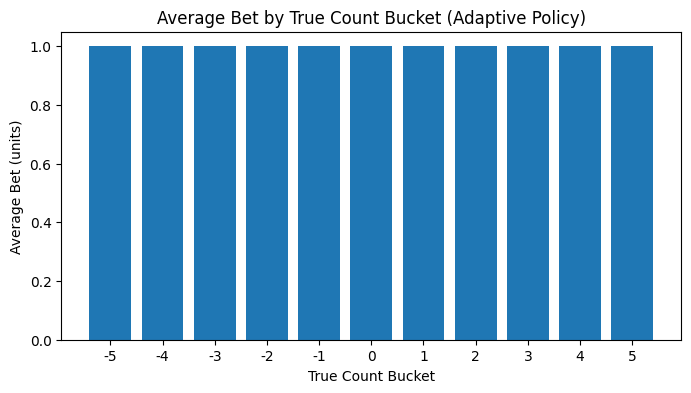

In [5]:
def play_one_hand_with_bet(env, play_policy, bet_units):
    tc, bucket = env.reset_for_bet()
    obs, immediate_reward, done = env.deal_and_start_hand()
    if done:
        return immediate_reward * bet_units, bucket
    total_reward = 0.0
    state = obs
    while True:
        action = play_policy.get(state, STAND)
        next_state, r, done, _ = env.step_play(action)
        total_reward += r
        state = next_state
        if done:
            break
    return total_reward * bet_units, bucket

def evaluate_strategies(env, play_policy, bet_policy, n=20000):
    rewards_flat = []
    rewards_adaptive = []
    bets_by_bucket = defaultdict(list)
    for _ in range(n):
        # flat bet (1 unit)
        r_flat, bucket = play_one_hand_with_bet(env, play_policy, bet_units=1)
        rewards_flat.append(r_flat)
        # adaptive: choose bet index from bet_policy using current bucket
        _, bucket_for_adapt = env.reset_for_bet()
        bi = bet_policy.get(bucket_for_adapt, 0)
        bet_units = BET_OPTIONS[bi]
        r_adapt, bucket_used = play_one_hand_with_bet(env, play_policy, bet_units=bet_units)
        rewards_adaptive.append(r_adapt)
        bets_by_bucket[bucket_used].append(bet_units)
    return np.array(rewards_flat), np.array(rewards_adaptive), bets_by_bucket

# Evaluate
env = CountingBlackjackEnv(n_decks=6, penetration=0.75)
rf, ra, bets_by_bucket = evaluate_strategies(env, policy_play, bet_policy, n=10000)

print("Flat EV per initial bet:", rf.mean(), "(", rf.mean()*100, "% )")
print("Adaptive EV per initial bet:", ra.mean(), "(", ra.mean()*100, "% )")
print("Win / Push / Loss (adaptive):", (ra>0).mean(), (ra==0).mean(), (ra<0).mean())

# Visualize average bet by bucket
bucket_means = {b: (np.mean(bets_by_bucket[b]) if len(bets_by_bucket[b])>0 else 0.0) for b in TRUE_COUNT_BUCKETS}
buckets = list(bucket_means.keys())
means = [bucket_means[b] for b in buckets]

plt.figure(figsize=(8,4))
plt.bar([str(b) for b in buckets], means)
plt.xlabel("True Count Bucket")
plt.ylabel("Average Bet (units)")
plt.title("Average Bet by True Count Bucket (Adaptive Policy)")
plt.show()